Import delle librerie

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import combinations
import random
import osmnx as ox

Definizione della funzione per la creazione della stringa nella formattazione corretta per la lettura da parte di Minizinc

In [2]:
def dataStringGenerator(df, nome_variabile):
    stringa = nome_variabile +" = [";
    ## sezione per la matrice delle distanze
    if df.shape[0] == df.shape[1]:
        for i in range(df.shape[0]):
            if i == 0:
                stringa = stringa + "| "
            else:
                stringa = stringa + "         | "
            for j in range(df.shape[1]):
                stringa = stringa + str(df.iat[i, j]) 
                if j != len(df)-1:
                    stringa = stringa + ", "
                else:
                    stringa = stringa +  os.linesep # aggiunta di \n a fine della riga 

        stringa = stringa + "         |];"
    # sezione per i semplici array di numeri
    else:
        for i in range(df.shape[0]):
            if i != df.shape[0]-1:
                stringa = stringa + str(df.iat[i,0]) + ", "
            else:
                stringa = stringa + str(df.iat[i,0])
        
        stringa = stringa + "];"
    
    return stringa

Definizione della funzione che permette la generazione di ordini casuali


In [3]:
def ordersGeneretor(orari_possibili, n_pizze_max, n_nodi, n_ordini):
    orari = np.random.choice(orari_possibili, size=n_ordini)
    #num_pizze = np.random.randint(1, n_pizze_max+1, size=n_ordini)
    xx = np.random.gamma(2,2, size=n_ordini)
    num_pizze = np.zeros(n_ordini, dtype=int)
    for i in range(n_ordini):
        num_pizze[i] = int(np.ceil(xx[i]))
        if num_pizze[i] > 16:
            num_pizze[i] = 16
            
    dest = np.random.randint(2, n_nodi+1, size=n_ordini)
    
    return orari, num_pizze, dest

##### Apertura e lettura del file

In [4]:
# Apertura e lettura del file
#file = open("data.txt","r")
#data = file.read()

df = pd.read_table('data.txt', sep=',', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,6,5,3,2,2,7,4,10,3,9,3,8,2,8,12
1,4,7,6,5,12,4,3,7,13,11,11,10,10,9,9,8,13,13
2,3,2,1,6,4,9,2,5,7,6,4,1,2,3,2,6,3,3


##### Divisione dei dati letti in input e creazione delle liste contenenti i nodi e i pesi relativi

La prima riga rappresenta il nodo di partenza di ogni arco, la seconda il node di arrivo e la terza il peso di ogni arco

In [5]:
# Divisione del file nelle tre righe di dati
#lista = data.split("\n")
# parsing in lista di interi
#da = [int(i) for i in lista[0].split(', ')]
#a = [int(i) for i in lista[1].split(', ')]
#pesi = [int(i) for i in lista[2].split(', ')]
da = df[0:1]
a = df[1:2]
pesi = df[2:3]


##### Generazione del grafo

In [6]:
#g = nx.Graph()
#for i in range(len(da)):
#     g.add_edge(da[i],a[i], weight=pesi[i])
#nx.draw_planar(g, with_labels = True)
#plt.savefig("prova.png")

In [7]:
# Creation of the graph
G = nx.Graph()

# Extract the nodes from the lists of edges and sort them
nodes = pd.unique(pd.concat([df.loc[0],df.loc[1]]))
nodes.sort()

for i in nodes:
    G.add_node(i)
    
for i in range(da.size):
    G.add_edge(df.iat[0,i], df.iat[1,i], weight=df.iat[2,i])

{(1, 4): Text(-0.42827209869185934, -0.04362760062031992, '3'),
 (1, 7): Text(0.03658217411698146, -0.2557579291913251, '2'),
 (1, 6): Text(0.26683784962221324, 0.06370297429845964, '1'),
 (2, 3): Text(-0.2655041032898721, -0.12131920665821178, '2'),
 (2, 7): Text(0.09971111754287651, -0.35546808487402337, '5'),
 (2, 8): Text(0.04724265785163217, -0.17489224258260194, '6'),
 (3, 4): Text(-0.5988406153513841, 0.027404176472081147, '9'),
 (3, 10): Text(-0.6599819480937441, 0.24655606843357106, '1'),
 (3, 9): Text(-0.42143809122476217, 0.19211295040885681, '3'),
 (4, 11): Text(-0.8412408345590585, 0.09586986415769913, '6'),
 (5, 6): Text(0.8458701146503345, 0.18094103538751605, '6'),
 (5, 12): Text(0.985311747272992, -0.027122317668036328, '4'),
 (7, 13): Text(0.3736678374430815, -0.3715159339895048, '7'),
 (8, 9): Text(-0.10869133008325786, 0.13853991448446665, '2'),
 (8, 13): Text(0.3211993777518372, -0.19094009169808335, '3'),
 (9, 10): Text(-0.5822184759432144, 0.38924629272554034, '2

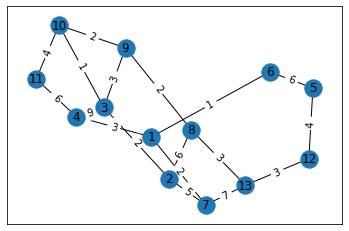

In [8]:
#nx.draw_planar(G, with_labels=True)
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

Generazione della matrice delle distanze

In [9]:
dictDist= dict(nx.all_pairs_dijkstra_path_length(G))

In [10]:
mDist = pd.DataFrame(dictDist)
mDistSorted = mDist.sort_index()

Creazione della stringa che sarà il file di input per il programma Minizinc e stampa su file

In [108]:
stringa = dataStringGenerator(mDistSorted, "mdist")

In [109]:
#file = open('myfile.dzn', 'w')
#file.write(stringa)
#file.close()

## Integrazione di OpenStreetMaps

Recupero di un grafo di una città e manipolazione per rendere utilizzabili le distanze

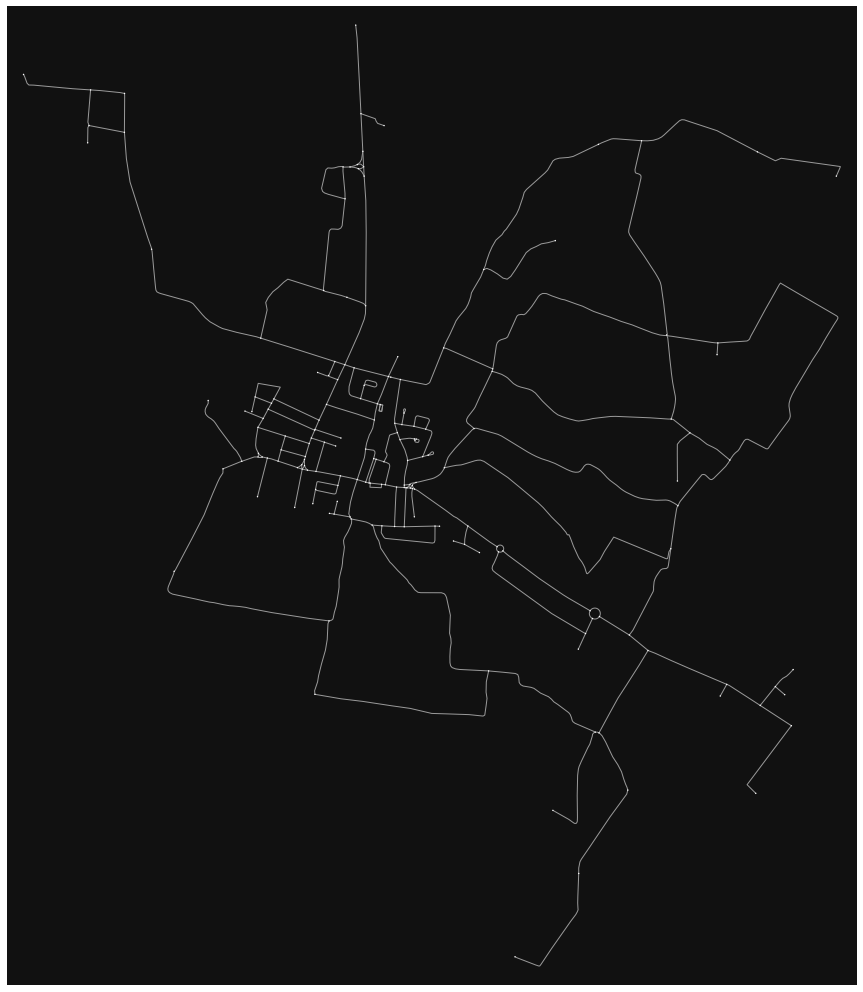

In [5]:
place_name = "Casaloldo, Mantova, Italy"

# dowload del grafico
graph = ox.graph_from_place(place_name, network_type="drive")
# conversione delle etichette con numeri consecutivi partendo da 1
gg = nx.convert_node_labels_to_integers(graph)
# conversione ad un grafo indiretto
dGraph = gg.to_undirected()

#type(dGraph)
fig, ax = ox.plot_graph(dGraph, node_size=2, figsize=(18,18))
#edge_centrality = nx.closeness_centrality(nx.line_graph(dGraph))
#nx.set_edge_attributes(dGraph, edge_centrality, "edge_centrality")
#ec = ox.plot.get_edge_colors_by_attr(dGraph, "length", cmap="inferno")
#fig, ax = ox.plot_graph(dGraph, edge_color=ec, edge_linewidth=0.8, node_size=10)
#type(graph)
#nx.classes.multidigraph.MultiDiGraph
#xx = nx.spring_layout(graph,k=1, dim=2, scale=2)
#plot = nx.draw_networkx(graph)
#nx.draw_planar(G, with_labels=True)
#pos=nx.spring_layout(G)
#nx.draw_networkx(G,pos)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [18]:
ox.basic_stats(dGraph)

{'n': 176,
 'm': 232,
 'k_avg': 2.6363636363636362,
 'edge_length_total': 45382.91300000001,
 'edge_length_avg': 195.61600431034486,
 'streets_per_node_avg': 2.715909090909091,
 'streets_per_node_counts': {0: 0, 1: 29, 2: 3, 3: 134, 4: 9, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.16477272727272727,
  2: 0.017045454545454544,
  3: 0.7613636363636364,
  4: 0.05113636363636364,
  5: 0.005681818181818182},
 'intersection_count': 147,
 'street_length_total': 45291.513000000006,
 'street_segment_count': 231,
 'street_length_avg': 196.06715584415588,
 'circuity_avg': 1.129025215260205,
 'self_loop_proportion': 0.017316017316017316}

In [19]:
# calcolo della minore distanza tra tutte le coppie di nodi
# --> la matrice sarà simmetrica perchè il grafo è indiretto
labels2 = nx.get_edge_attributes(dGraph, 'length')
dictDist2 = dict(nx.all_pairs_dijkstra_path_length(dGraph))
mDist2 = pd.DataFrame(dictDist2)
mDistSorted2 = mDist2.sort_index()
#mDistSorted3 = mDistSorted2.reset_index()
#mDistSorted4 = mDistSorted3.T.reset_index()
mDistSorted2.head()

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,0,2,5,8,13,4,6,11,17,13,...,15,15,14,17,11,14,13,13,12,13
1,2,0,4,7,12,3,5,10,16,12,...,14,14,13,16,11,13,12,12,11,12
2,5,4,0,3,11,7,9,10,15,11,...,13,13,12,15,12,15,16,16,15,16
3,8,7,3,0,8,6,6,7,12,8,...,10,10,9,12,12,12,13,13,12,13
4,13,12,11,8,0,9,9,8,8,4,...,6,6,5,8,15,12,13,13,12,14


In [6]:
##### xx=nx.spring_layout(graph)
#nx.draw_networkx(graph,xx)

#RandG = nx.gnm_random_graph(10,18,seed=1234)
#posG=nx.spring_layout(RandG)
#nx.draw_networkx(RandG,posG)

#for i in RandG.edges:
#    G.add_edges_from(i, weight=np.random())
#np.random.randint(low=1,high=15)


def ER(n, p):
    V = set([v for v in range(n)])
    
    g = nx.Graph()
    g.add_nodes_from(V)
    
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            g.add_edge(combination[0], combination[1])
        
        flag = nx.check_planarity(g)
        if  flag[0] == False:
            g.remove_edge(combination[0], combination[1])
    
    return g

#G = ER(15,0.6)
#xx=nx.planar_layout(G)
#nx.draw_networkx(G,xx)
#
#graph = nx.fast_gnp_random_graph(10,2)
#xx=nx.spring_layout(graph)
#nx.draw_networkx(graph,xx)


## Generazione dei file di dati da dare in input a minizinc

In [8]:
orari_possibili = ["19.00", "19.15", "19.30", "19.45", "20.00", "20.15", "20.30", "20.45", "21.00", "21.15", "21.30"]
# np.random.randint(1,17) --> generatore di numeri tra [1,16] aka generatore di numero di pizze
# np.random.randint(2,len(mDistSorted2)+1) aka generatore di destinazioni
#orario
#num_pizze
#dest

deliverers = 3
N = 8
orari, pizze, nodi = ordersGeneretor(orari_possibili, 16, mDistSorted2.shape[0], N)
dfOrari = pd.DataFrame(orari)
dfPizze = pd.DataFrame(pizze)
dfNodi = pd.DataFrame(nodi)


stringa = dataStringGenerator(pd.DataFrame(mDistSorted2,dtype=int), "mdist")
stringaOrari = dataStringGenerator(dfOrari, "orario")
stringaPizze = dataStringGenerator(dfPizze, "num_pizze")
stringaNodi = dataStringGenerator(dfNodi, "dest")

file = open('data.dzn', 'w')
file.write(stringa + os.linesep 
           + stringaOrari + os.linesep 
           + stringaPizze + os.linesep 
           + stringaNodi+ os.linesep
           + "N = " + str(N) + ";" + os.linesep
           + "k = " + str(mDistSorted2.shape[0]) + ";" + os.linesep
           + "d = " + str(deliverers) + ";" + os.linesep)
file.close()

## Generate 5 city of increasing size

In [2]:
import seaborn as sb
import os
import time

names = ["Visano", "Asola","Montichiari","Brescia","Roma"]
places = [(45.317468,10.3694991), # Visano (BS)
        (45.221332657542824, 10.41757427434648), # Asola (MN)
        (45.41301145796791, 10.39169903519818), # Montichiari (BS)
        (45.536282844234854, 10.206297121183406), # Brescia (BS)
        (41.90343248728792, 12.496484448996995)] # Roma (RO)

In [5]:
graphs = []

for c in places:
    graph = ox.graph_from_point(c,dist=3000,network_type="drive")
    # conversions
    graph = nx.convert_node_labels_to_integers(graph)
    graph = graph.to_undirected()
    
    graphs.append(graph) 
    # plot
    print(names[places.index(c)])
    #fig, ax = ox.plot_graph(graph, node_size=2, figsize=(50,50))
    # print statistics
    print('nodes: ' + str(ox.basic_stats(graph)['n']))
    print('edges: ' + str(ox.basic_stats(graph)['m']))
        

Visano
nodes: 297
edges: 378
Asola
nodes: 480
edges: 664
Montichiari
nodes: 1130
edges: 1509
Brescia
nodes: 3925
edges: 5464
Roma
nodes: 4729
edges: 7277


In [6]:
# Calculate distances

# --> la matrice sarà simmetrica perchè il grafo è indiretto

mDists = []

for g in graphs:
    
    print(names[graphs.index(g)])
    
    labels = nx.get_edge_attributes(g, 'length')
    dictDist = dict(nx.all_pairs_dijkstra_path_length(g,weight='length'))
    mDist = pd.DataFrame(dictDist)
    mDists.append(mDist)
    mDistSorted = mDist.sort_index()


    print(mDistSorted.head())

Visano
        0         1         2         3         4         5         6    \
0     0.000  1796.021  1327.796  1292.057  1275.530  1256.546   765.177   
1  1796.021     0.000   468.225   504.052   520.579   539.563  1030.844   
2  1327.796   468.225     0.000    35.827    52.354    71.338   562.619   
3  1292.057   504.052    35.827     0.000    16.527    35.511   526.880   
4  1275.530   520.579    52.354    16.527     0.000    18.984   510.353   

        7         8         9    ...       287       288       289       290  \
0   736.394   720.987   677.430  ...  5458.407  5606.908  5386.025  5325.188   
1  1060.587  1075.994  1119.551  ...  4474.024  4622.525  4546.406  4607.243   
2   592.362   607.769   651.326  ...  4942.249  5090.750  5014.631  5075.468   
3   556.623   572.030   615.587  ...  4978.076  5126.577  5050.458  5111.295   
4   540.096   555.503   599.060  ...  4994.603  5143.104  5066.985  5127.822   

        291       292       293       294       295       296

In [20]:
# Generate files

orari_possibili = ["19.00", "19.15", "19.30", "19.45", "20.00", "20.15", "20.30", "20.45", "21.00", "21.15", "21.30"]


times = pd.DataFrame(columns=['city','time','unsat'])

for g in graphs:
    
    for i in range(10):
        
        print(names[graphs.index(g)] + "...  " + str(i+1) + "/10  ", end ="\r")
        
        N = np.random.randint(5,15)
        deliverers = np.random.randint(3,5)

        orari, pizze, nodi = ordersGeneretor(orari_possibili, 16, mDists[graphs.index(g)].shape[0], N)
            
        dfOrari = pd.DataFrame(orari)
        dfPizze = pd.DataFrame(pizze)
        dfNodi  = pd.DataFrame(nodi)


        stringa = dataStringGenerator(pd.DataFrame(mDists[graphs.index(g)]/500,dtype=int), "mdist")
        stringaOrari = dataStringGenerator(dfOrari, "orario")
        stringaPizze = dataStringGenerator(dfPizze, "num_pizze")
        stringaNodi = dataStringGenerator(dfNodi, "dest")

        filename = 'data/data_'+names[graphs.index(g)]+'_'+str(i)+'.dzn'
        file = open(filename, 'w')
        file.write(stringa + os.linesep 
                   + stringaOrari + os.linesep 
                   + stringaPizze + os.linesep 
                   + stringaNodi+ os.linesep
                   + "N = " + str(N) + ";" + os.linesep
                   + "k = " + str(mDists[graphs.index(g)].shape[0]) + ";" + os.linesep
                   + "d = " + str(deliverers) + ";" + os.linesep)
        file.close()
        
    print()

Visano...  10/10  
Asola...  10/10  
Montichiari...  10/10  
Brescia...  10/10  
Roma...  10/10  


Execution

In [21]:
times = pd.DataFrame(columns=['city','time','unsat'])

for n in names:
    
    unsat = 0
    
    for i in range(10):
        
        print(str(i+1) + "/10 - " + n + "...   ", end ="\r")
        
        filename = 'data/data_'+ n +'_'+str(i)+'.dzn'
        start_time = time.time()
        cmd = 'minizinc --solver Gecode --time-limit 120000 v01.mzn ' + filename
        #print(str(i) + ' - ' + cmd)
        out = os.popen(cmd).read()
        unsat += ('UNSAT' in out)
        row = {'city': n, 'time': (time.time() - start_time),'unsat': ('UNSAT' in out)}
        times = times.append(row, ignore_index = True)
        
        times.to_csv('res.csv', index=False)
        
    print()
    print('\t unsat #: ' + str(unsat))
    

10/10 - Visano...   
	 unsat #: 6
10/10 - Asola...   
	 unsat #: 3
10/10 - Montichiari...   
	 unsat #: 3
10/10 - Brescia...   
	 unsat #: 0
10/10 - Roma...   
	 unsat #: 0


Results

           city        time  unsat
0        Visano    8.041038  False
1        Visano    5.084732  False
2        Visano    2.216951  False
3        Visano    2.477594   True
4        Visano    4.602448   True
5        Visano    3.530729  False
6        Visano    2.860569   True
7        Visano    2.949737   True
8        Visano    4.500173   True
9        Visano    3.337299   True
10        Asola   22.461843  False
11        Asola   12.076752  False
12        Asola    8.982483  False
13        Asola   11.551985  False
14        Asola   14.368703   True
15        Asola   10.683048   True
16        Asola    5.686339  False
17        Asola   12.731214  False
18        Asola    5.187607  False
19        Asola    5.780768   True
20  Montichiari   80.477426  False
21  Montichiari   61.607104  False
22  Montichiari   50.775605  False
23  Montichiari   28.952572  False
24  Montichiari   54.543316   True
25  Montichiari   37.627450  False
26  Montichiari   64.903966  False
27  Montichiari   81

<AxesSubplot:xlabel='city', ylabel='time'>

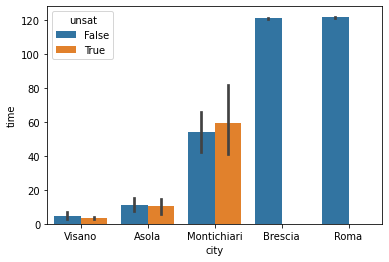

In [22]:
times = pd.read_csv('res.csv')  
print(times)

sb.barplot(data=times, x="city", y="time", hue="unsat")